# Multi-Modal Data Fusion - Project Work: Multi-Modal Physical Exercise Classification


In this project, real multi-modal data is studied by utilizing different techniques presented during the course. In addition, there is an optional task to try some different approaches to identify persons from the same dataset. Open MEx dataset from UCI machine learning repository is used. Idea is to apply different techniques to recognize physical exercises from wearable sensors and depth camera, user-independently.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Author(s)
Add your information here

Name(s): Md Rabiul Hasan, Abu Taher

Student number(s):2410234, 2410233

## Description

The goal of this project is to develop user-independent pre-processing and classification models to recognize 7 different physical exercises measured by accelerometer (attached to subject's thigh) and depth camera (above the subject facing downwards recording an aerial view). All the exercises were performed subject lying down on the mat. Original dataset have also another acceleration sensor and pressure-sensitive mat, but those two modalities are ommited in this project. There are totally 30 subjects in the original dataset, and in this work subset of 10 person is utilized. Detailed description of the dataset and original data can be access in [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#). We are providing the subset of dataset in Moodle.

The project work is divided on following phases:

1. Data preparation, exploration, and visualization
2. Feature extraction and unimodal fusion for classification
3. Feature extraction and feature-level fusion for multimodal classification
4. Decision-level fusion for multimodal classification
5. Bonus task: Multimodal biometric identification of persons

where 1-4 are compulsory (max. 10 points each), and 5 is optional to get bonus points (max. 5+5 points). In each phase, you should visualize and analyse the results and document the work and findings properly by text blocks and figures between the code. <b> Nice looking </b> and <b> informative </b> notebook representing your results and analysis will be part of the grading in addition to actual implementation.

The results are validated using confusion matrices and F1 scores. F1 macro score is given as
<br>
<br>
$
\begin{equation}
F1_{macro} = \frac{1}{N} \sum_i^N F1_i,
\end{equation}
$
<br>
<br>
where $F1_i = 2  \frac{precision_i * recall_i}{precision_i + recall_i}$, and $N$ is the number of classes.
<br>

## Learning goals

After the project work, you should  

- be able to study real world multi-modal data
- be able to apply different data fusion techniques to real-world problem
- be able to evaluate the results
- be able to analyse the outcome
- be able to document your work properly

## Relevant lectures

Lectures 1-8

## Relevant exercises

Exercises 0-6

## Relevant chapters in course book

Chapter 1-14

## Additional Material

* Original dataset [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#)
* Related scientific article [MEx: Multi-modal Exercises Dataset for Human Activity Recognition](https://arxiv.org/pdf/1908.08992.pdf)

# 1. Data preparation, exploration, and visualization

<a id='task1'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 1.</b>

Download data from the Moodle's Project section. Get yourself familiar with the folder structure and data. You can read the data files using the function given below. Each file consists one exercise type performed by single user. Data are divided on multiple folders. Note that, in each folder there is one long sequence of single exercise, except exercise 4 which is performed two times in different ways. Those two sequences belongs to same class. Do the following subtasks to pre-analyse data examples and to prepare the training and testing data for next tasks:
<br>
<br>
<p> Read raw data from the files. Prepare and divide each data file to shorter sequences using windowing method. Similar to related article "MEx: Multi-modal Exercises Dataset for Human Activity Recognition", use 5 second window and 3 second overlapping between windows, producing several example sequences from one exercise file for classification purposes. Windowing is working so that starting from the beginning of each long exercise sequence, take 5 seconds of data points (from synchronized acceleration data and depth images) based on the time stamps. Next, move the window 2 seconds forward and take another 5 seconds of data. Then continue this until your are at the end of sequence. Each window will consists 500x3 matrix of acceleration data and 5x192 matrix of depth image data.</p>

</div>

In [ ]:
# Import relevant libraries here
from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from scipy import signal
from sklearn import metrics
from scipy import stats
from sklearn.preprocessing import minmax_scale
# Enter data folder location
loc = "/content/drive/MyDrive/Multi Modal Data Fusion/MEx"

In [ ]:
"""
    IMPORTANT: PLEASE DO NOT MODIFY THE CODE IN THIS CELL.
"""
def path_to_meta(p):
    meta = dict()
    meta["subject_id"] = p.parent.stem
    meta["exercise_id"] = p.stem.split("_")[-2]
    meta["trial"] = int(p.stem.split("_")[-1])
    meta["sensor_code"] = p.stem.split("_")[0]
    meta["sensor"] = {"act": "acc", "dc": "dc"}[meta["sensor_code"]]
    return meta

# Find, read, and compose the measurements
paths_record = Path(loc).glob("*/*/*.csv")

records = []

for path_record in paths_record:
    df = pd.read_csv(path_record, delimiter=",", header=None)
    meta = path_to_meta(path_record)

    if meta["sensor"] == "acc":
        col_names = ["time", "acc_0", "acc_1", "acc_2"]       #Column for acc
        df.columns = col_names
    else:
        num_cols = df.shape[1]
        col_names = ["time", ] + [f"dc_{i}" for i in range(num_cols-1)]        # Column for depth camera
        df.columns = col_names

    meta["df"] = df

    records.append(meta)

df_records = pd.DataFrame.from_records(records)

print(f"Total records found: {len(df_records)}")
print("Dataframe with all records:")
display(df_records.head())
print("Dataframe with one measurement series:")
display(df_records["df"].iloc[0].head())

Total records found: 160
Dataframe with all records:


,subject_id,exercise_id,trial,sensor_code,sensor,df
0,03,04,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...
1,03,03,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...
2,03,04,2,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...
3,03,02,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...
4,03,05,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...


Dataframe with one measurement series:


,time,dc_0,dc_1,dc_2,dc_3,dc_4,dc_5,dc_6,dc_7,dc_8,...,dc_182,dc_183,dc_184,dc_185,dc_186,dc_187,dc_188,dc_189,dc_190,dc_191
0,0.0,0.4643,0.9278,0.9351,0.9343,0.9319,0.9288,0.9258,0.9224,0.9216,...,0.9683,0.9673,0.9644,0.9620,0.9612,0.9604,0.9581,0.9581,0.9509,0.9501
1,1000.0,0.4643,0.9278,0.9351,0.9343,0.9319,0.9288,0.9258,0.9230,0.9216,...,0.9683,0.9664,0.9644,0.9636,0.9612,0.9612,0.9581,0.9581,0.9509,0.9509
2,2000.0,0.4643,0.9288,0.9351,0.9319,0.9319,0.9288,0.9258,0.9224,0.9224,...,0.9683,0.9664,0.9644,0.9628,0.9612,0.9581,0.9581,0.9573,0.9509,0.9509
3,3000.0,0.4643,0.9288,0.9351,0.9351,0.9319,0.9288,0.9258,0.9224,0.9224,...,0.9691,0.9673,0.9644,0.9628,0.9612,0.9589,0.9581,0.9581,0.9509,0.9501
4,4000.0,0.4651,0.9288,0.9351,0.9351,0.9319,0.9288,0.9258,0.9224,0.9216,...,0.9683,0.9683,0.9644,0.9620,0.9612,0.9604,0.9581,0.9581,0.9509,0.9509


In [ ]:
"""
    IMPORTANT: PLEASE DO NOT MODIFY THE CODE IN THIS CELL.
"""

# Extract 5-second long windows with 2-second shift (3-second overlap)

records_windowed = []

time_window = 5000.
time_offset = 2000.

for row_idx, row_data in df_records.iterrows():
    df_tmp = row_data["df"]           # Extract the raw data (DataFrame) for the current record
    time_start = np.min(df_tmp["time"].to_numpy())     # Start time of the signal
    time_end = np.max(df_tmp["time"].to_numpy())       # End time of the signal

    for window_idx, t0 in enumerate(np.arange(time_start, time_end, time_offset)):
        t1 = t0 + time_window
        # Handle boundary conditions - skip the measurements from the end shorter than window size
        if t1 > time_end:
            continue

        tmp_data = deepcopy(row_data)          # Create a deep copy of the current record's metadata and data
        tmp_data["window_idx"] = window_idx    # Assign a window index
        tmp_data["df"] = df_tmp[(df_tmp["time"] >= t0) &
                                (df_tmp["time"] < t1)].copy()

        records_windowed.append(tmp_data)

df_records_windowed = pd.DataFrame.from_records(records_windowed)

print(f"Total windows extracted: {len(df_records_windowed)}")
print("Dataframe with all windowed records:")
display(df_records_windowed.head())
print("Dataframe with one windowed measurement series:")
display(df_records_windowed["df"].iloc[0].head())

Total windows extracted: 4169
Dataframe with all windowed records:


,subject_id,exercise_id,trial,sensor_code,sensor,df,window_idx
0,03,04,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 d...,0
1,03,04,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 d...,1
2,03,04,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 d...,2
3,03,04,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,3
4,03,04,1,dc,dc,time dc_0 dc_1 dc_2 dc_3 ...,4


Dataframe with one windowed measurement series:


,time,dc_0,dc_1,dc_2,dc_3,dc_4,dc_5,dc_6,dc_7,dc_8,...,dc_182,dc_183,dc_184,dc_185,dc_186,dc_187,dc_188,dc_189,dc_190,dc_191
0,0.0,0.4643,0.9278,0.9351,0.9343,0.9319,0.9288,0.9258,0.9224,0.9216,...,0.9683,0.9673,0.9644,0.9620,0.9612,0.9604,0.9581,0.9581,0.9509,0.9501
1,1000.0,0.4643,0.9278,0.9351,0.9343,0.9319,0.9288,0.9258,0.9230,0.9216,...,0.9683,0.9664,0.9644,0.9636,0.9612,0.9612,0.9581,0.9581,0.9509,0.9509
2,2000.0,0.4643,0.9288,0.9351,0.9319,0.9319,0.9288,0.9258,0.9224,0.9224,...,0.9683,0.9664,0.9644,0.9628,0.9612,0.9581,0.9581,0.9573,0.9509,0.9509
3,3000.0,0.4643,0.9288,0.9351,0.9351,0.9319,0.9288,0.9258,0.9224,0.9224,...,0.9691,0.9673,0.9644,0.9628,0.9612,0.9589,0.9581,0.9581,0.9509,0.9501
4,4000.0,0.4651,0.9288,0.9351,0.9351,0.9319,0.9288,0.9258,0.9224,0.9216,...,0.9683,0.9683,0.9644,0.9620,0.9612,0.9604,0.9581,0.9581,0.9509,0.9509


<a id='task1'></a>
<div class=" alert alert-warning">
     
<p> <b>1.1</b> Plot few examples of prepared data for each modalities (accelometer and depth camera). Plot acceleration sensor as multi-dimensional time-series and depth camera data as 2D image. Plot 5 second acceleration sensor and depth image sequences of person 1 and 5 performing exercises 2, 5, and 6. Take the first windowed example from the long exercise sequence. </p>

</div>

Index(['subject_id', 'exercise_id', 'trial', 'sensor_code', 'sensor', 'df',
       'window_idx'],
      dtype='object')


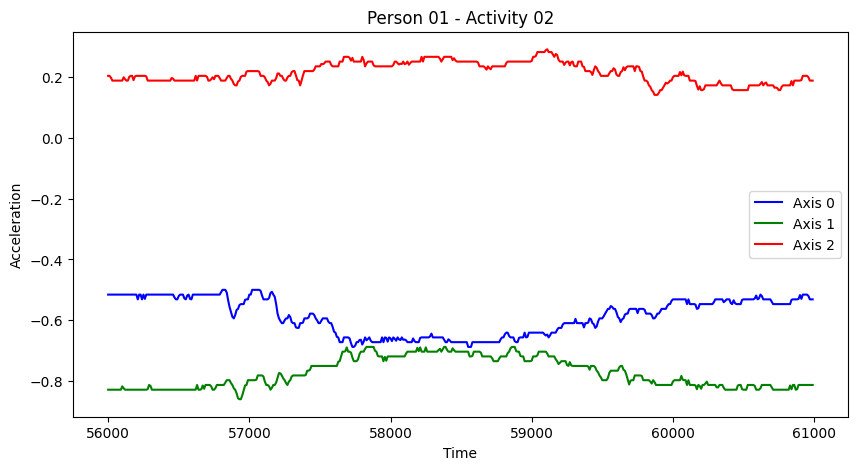

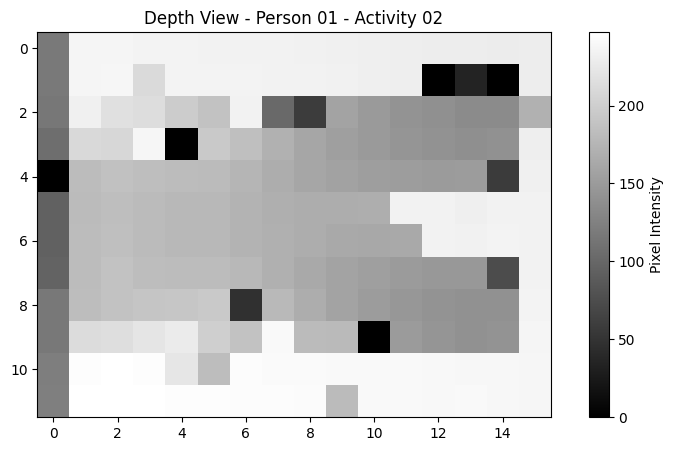

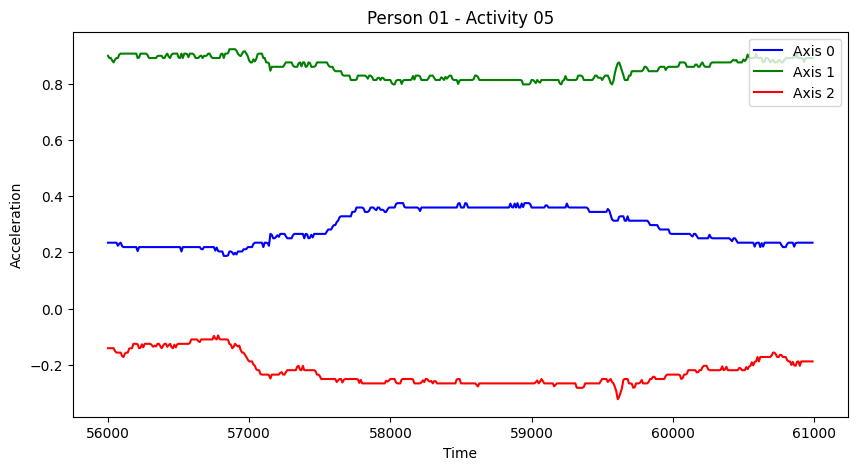

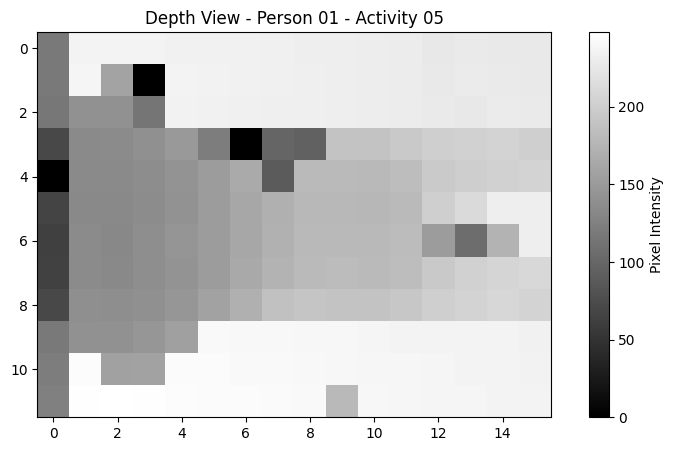

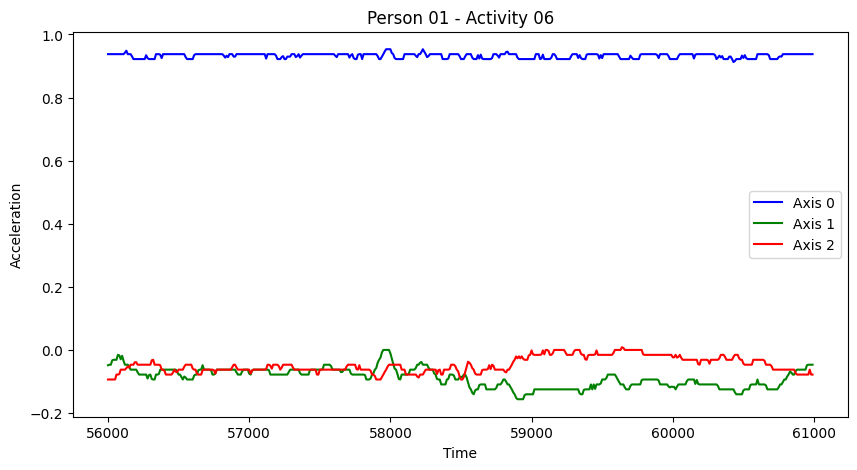

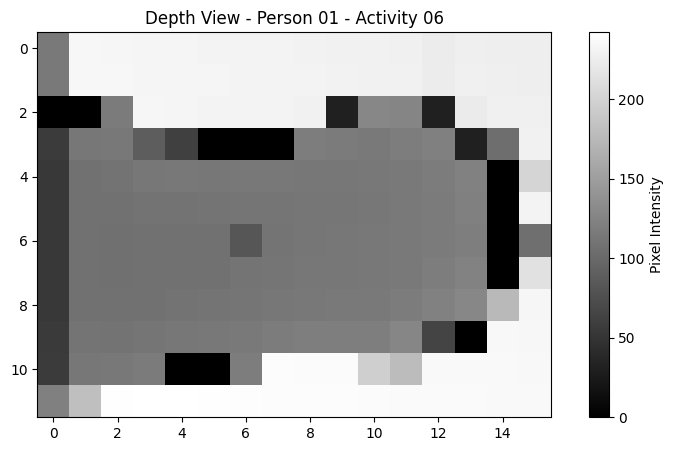

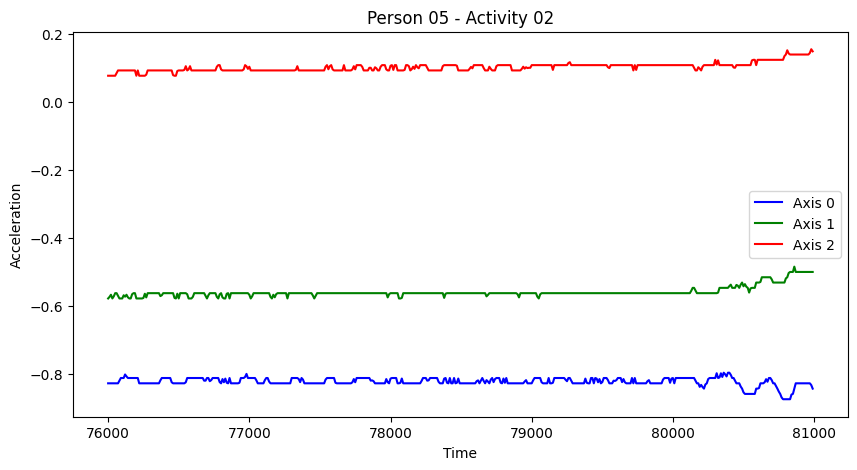

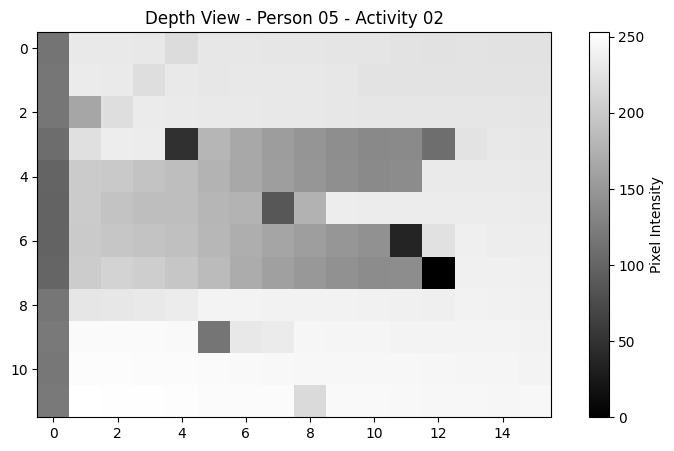

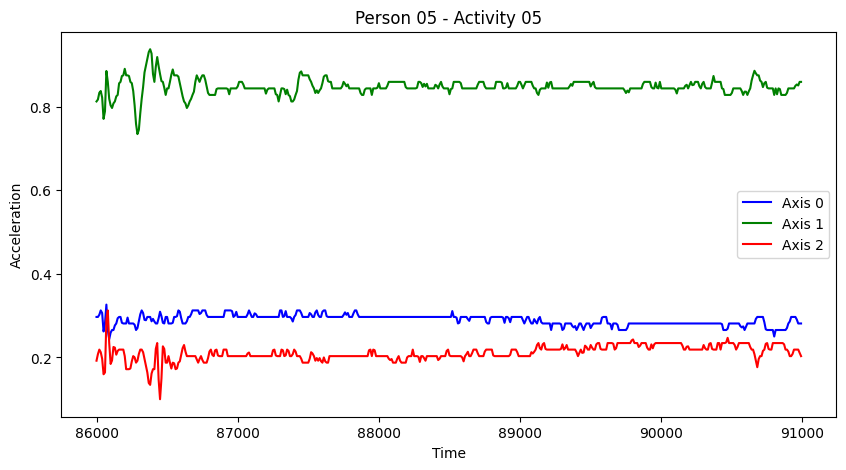

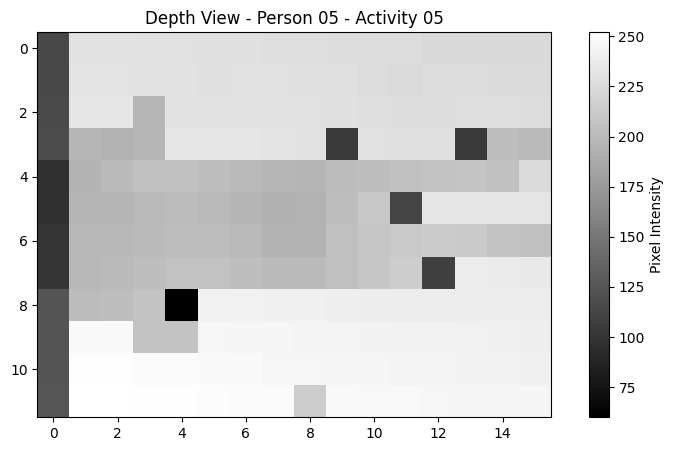

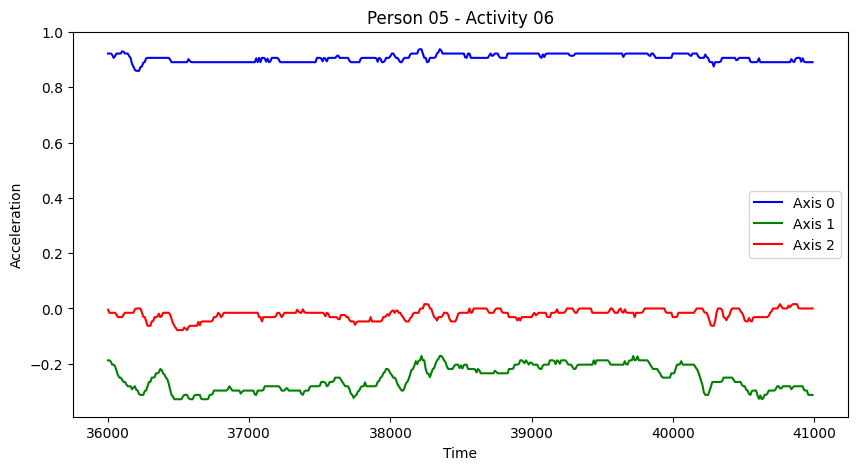

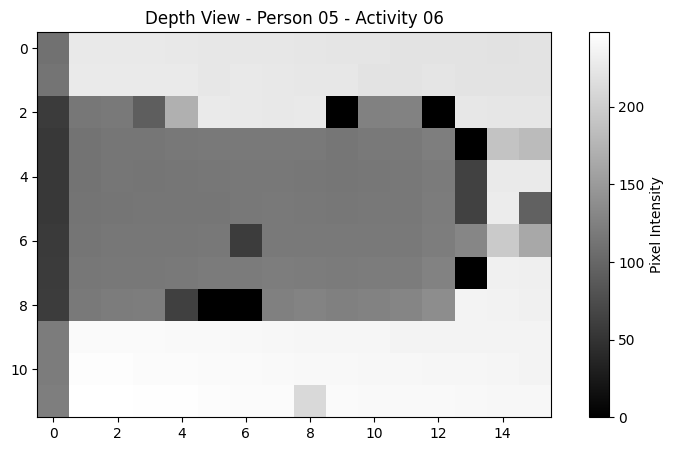

In [ ]:
# Function to filter data based on individual ID and activity ID
def filter_data(individual_id, activity_id):
    """
    Filters the dataset for the specified individual and activity.
    """
    filtered_data = df_records_windowed[
        (df_records_windowed['subject_id'] == individual_id) &
        (df_records_windowed['exercise_id'] == activity_id)
    ]
    return filtered_data

# Retrieve data for specific activities for subject 1
subject1_activity2 = filter_data('01', '02')
subject1_activity5 = filter_data('01', '05')
subject1_activity6 = filter_data('01', '06')

# Retrieve data for specific activities for subject 5
subject5_activity2 = filter_data('05', '02')
subject5_activity5 = filter_data('05', '05')
subject5_activity6 = filter_data('05', '06')

# Function to locate indices for sensor and depth camera data
def locate_indices(data_frame):
    """
    Identifies indices of accelerometer and depth camera entries in the dataset.
    """
    accel_index, depth_index = -1, -1
    for i in range(len(data_frame)):
        if data_frame['df'].iloc[i].shape[1] == 4:  # 4 columns for accelerometer data. Identified by 4 columns (time, acc_0, acc_1, acc_2).
            accel_index = i
        elif data_frame['df'].iloc[i].shape[1] == 193:  # 193 columns for depth camera data. Identified by 193 columns (time + 192 depth pixel values)
            depth_index = i
    return accel_index, depth_index

# Print column names for verification
print(subject1_activity2.columns)

# Import necessary libraries for visualization
from PIL import Image
import matplotlib.pyplot as plt

# Function to plot accelerometer readings
def plot_accelerometer(sensor_data, idx, title):
    """
    Plots accelerometer readings from the dataset.
    """
    plt.figure(figsize=(10, 5))
    for axis in range(3):  # Acceleration axes: x, y, z
        plt.plot(
            sensor_data['df'].iloc[idx]['time'],
            sensor_data['df'].iloc[idx][f'acc_{axis}'],
            color=['blue', 'green', 'red'][axis],
            label=f'Axis {axis}'
        )
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.title(title)
    plt.legend()

# Function to render depth camera data as an image
def render_depth_image(data_frame, caption):
    """
    Displays depth camera data as a grayscale image.
    """
    plt.figure(figsize=(10, 5))
    accel_idx, depth_idx = locate_indices(data_frame) # Find depth camera row index
    depth_data = data_frame['df'].iloc[depth_idx].drop('time', axis=1) # Drop 'time' column

    depth_array = depth_data[depth_data.columns].values[0] # Extract depth pixel values
    depth_image = depth_array.reshape(12, 16)  # # Reshape into 12x16 image
    grayscale_image = Image.fromarray((depth_image * 255).astype('uint8'), mode='L') # Scale and convert to grayscale
    plt.imshow(grayscale_image, cmap='gray')
    plt.title(caption)
    plt.colorbar(label='Pixel Intensity')

# Collection of datasets for visualization
data_collections = [subject1_activity2, subject1_activity5, subject1_activity6,
                    subject5_activity2, subject5_activity5, subject5_activity6]

# Function to handle both accelerometer and depth camera visualizations
def visualize_combined(data_set):
    """
    Plots both accelerometer and depth camera visuals for the dataset.
    """
    accel_idx, depth_idx = locate_indices(data_set)
    plot_accelerometer(
        data_set,
        accel_idx,
        f'Person {data_set["subject_id"].iloc[0]} - Activity {data_set["exercise_id"].iloc[0]}'
    )
    render_depth_image(
        data_set,
        f'Depth View - Person {data_set["subject_id"].iloc[0]} - Activity {data_set["exercise_id"].iloc[0]}'
    )

# Iterate through datasets to generate visualizations
for data_set in data_collections:
    visualize_combined(data_set)


<a id='task1'></a>
<div class=" alert alert-warning">

<p> <b>1.2</b> Split the prepared dataset to training and testing datasets so that data of persons 1-7 are used for training and data of persons 8-10 are used for testing. In next tasks, training dataset could be further divided on (multiple) validation data folds to tune the models parameters, when needed.<br>
    
<p> Note: Training set should have 1486 windows and testing set should have 598 windows. In training set, acceleration data will have a window without a pair with depth camera data, that window should be dropped as it doesn't have a pair.<p>
  
Document your work, calculate the indicator statistics of training and testing datasets (number of examples, dimensions of each example) and visualize prepared examples.

</div>

Step 1: Define Training and Testing Subjects

In [ ]:
# Define the subject IDs for training and testing datasets
def get_subjects():
    all_subjects = [f"{i:02}" for i in range(1, 11)]
    Training_Subjects = all_subjects[:7]
    Testing_Subjects = all_subjects[7:]
    return Training_Subjects, Testing_Subjects

# Get training and testing subjects
Training_Subjects, Testing_Subjects = get_subjects()

Step 2: Filter Training Data by Sensor Type

In [ ]:
# Function to filter data based on subject group and sensor type
def extract_sensor_data(df, subjects, sensor_type):
    return df[(df['subject_id'].isin(subjects)) & (df['sensor'] == sensor_type)]

# Extract training data for accelerometer and depth camera
Training_Acc = extract_sensor_data(df_records_windowed, Training_Subjects, 'acc')
Training_Dc = extract_sensor_data(df_records_windowed, Training_Subjects, 'dc')

Step 3: Filter Testing Data by Sensor Type

In [ ]:
# Function to extract data based on subject group and sensor type
def extract_sensor_data(df, subjects, sensor_type):
    return df[(df['subject_id'].isin(subjects)) & (df['sensor'] == sensor_type)]

# Extract testing data for accelerometer and depth camera
Test_Acc = extract_sensor_data(df_records_windowed, Testing_Subjects, 'acc')
Test_Dc = extract_sensor_data(df_records_windowed, Testing_Subjects, 'dc')

Step 4: Reset Indices for Clean Merging

In [ ]:
# Reset the indices for training data
Training_Acc = Training_Acc.reset_index(drop=True) # old index is not added as a new column in the DataFrame.
Training_Dc = Training_Dc.reset_index(drop=True)

# Reset the indices for testing data
Test_Acc = Test_Acc.reset_index(drop=True)
Test_Dc = Test_Dc.reset_index(drop=True)

Step 5: Merge Training Data

In [ ]:
# Function to merge datasets based on common columns
def merge_datasets(df1, df2, join_columns):
    return pd.merge(df1, df2, how="inner", on=join_columns)

# Merge training accelerometer and depth camera datasets
train = merge_datasets(
    Training_Acc,
    Training_Dc,
    ['subject_id', 'exercise_id', 'trial', 'window_idx']
)

Step 6: Merge Testing Data

In [ ]:
# Function to merge datasets based on common columns
def merge_datasets(df1, df2, join_columns):
    return pd.merge(df1, df2, how="inner", on=join_columns)

# Merge testing accelerometer and depth camera datasets
test = merge_datasets(
    Test_Acc,
    Test_Dc,
    ['subject_id', 'exercise_id', 'trial', 'window_idx']
)

Step 7: Display Dataset Statistics

In [ ]:
print("Number of accelerometer training samples:", len(Training_Acc))
print("Number of accelerometer testing samples:", len(Test_Acc))
print("Number of depth camera training samples:", len(Training_Dc))
print("Number of depth camera testing samples:", len(Test_Dc))
print("Total samples in merged training dataset:", len(train))
print("Shape of training dataset:", train.shape)
print("Shape of testing dataset:", test.shape)
print("Total samples in merged testing dataset:", len(test))
print("Total entries in the windowed DataFrame:", len(df_records_windowed))


Number of accelerometer training samples: 1487
Number of accelerometer testing samples: 598
Number of depth camera training samples: 1486
Number of depth camera testing samples: 598
Total samples in merged training dataset: 1486
Shape of training dataset: (1486, 10)
Shape of testing dataset: (598, 10)
Total samples in merged testing dataset: 598
Total entries in the windowed DataFrame: 4169


Step 8: Visualize Training and Testing Data

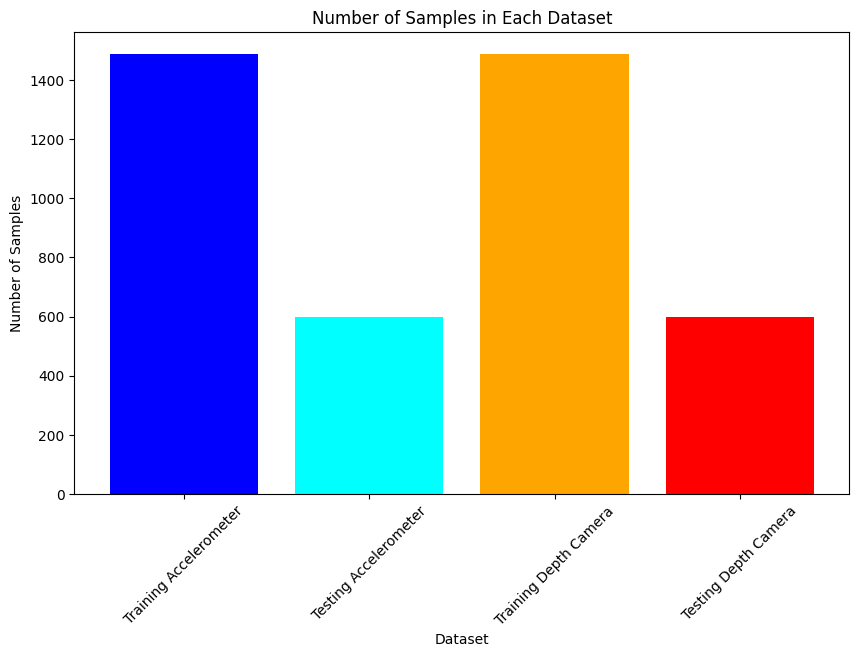

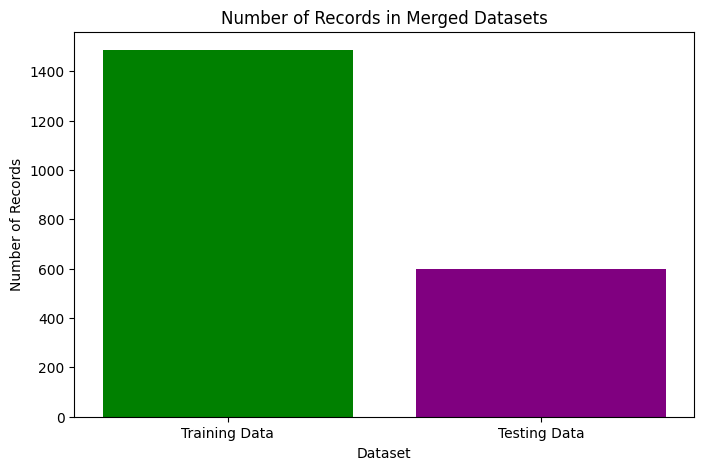

In [ ]:
def visualize_data_stats():
    labels = ['Training Accelerometer', 'Testing Accelerometer', 'Training Depth Camera', 'Testing Depth Camera']
    counts = [len(Training_Acc), len(Test_Acc), len(Training_Dc), len(Test_Dc)]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color=['blue', 'cyan', 'orange', 'red'])
    plt.title('Number of Samples in Each Dataset')
    plt.xlabel('Dataset')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.show()

# Visualize the dimensions of the merged datasets
def visualize_merged_data():
    labels = ['Training Data', 'Testing Data']
    dimensions = [train.shape[0], test.shape[0]]

    plt.figure(figsize=(8, 5))
    plt.bar(labels, dimensions, color=['green', 'purple'])
    plt.title('Number of Records in Merged Datasets')
    plt.xlabel('Dataset')
    plt.ylabel('Number of Records')
    plt.show()

# Call the visualization functions
visualize_data_stats()
visualize_merged_data()

# 2. Feature extraction and fusion for unimodal classification

<a id='task2'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 2.</b>

Use the training dataset prepared in task 1. to build models based on the combination of principal component analysis (PCA), linear discriminant analysis (LDA), and nearest neighbour (NN) classifier for each modality separately and evaluate the model on test dataset. Do the subtasks given as
<br>
<br>
<p> <b>2.1</b> Calculate PCA and LDA transformations to reduce the dimensionality of accelerometer data (e.g., using scikit-learn implementations). Before transformations downsample data from 100 Hz to 25 Hz (using scipy.signal.resample) to get 125x3 matrix of data for each 5 sec window. You should also standardize the values to zero mean and unit variance before the transformations. Using training dataset, fit PCA with 5-dimensional subspace (i.e., choosing the 5 largest principal components) and fit LDA with 5-dimensional subspace. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 3x(5+5). Perform the fusion of PCA and LDA similar manner as presented in Lecture 3 (pages 24-25) using NN method. Evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>

Note: Standardize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes (The expected F1 score for this task should generally fall within the range of 40 to 50)
    
</div>

Step 1: Drop Time Column from DataFrames

In [ ]:

def Time_Column_Remove(dataframes):
    """
    Remove the 'time' column from the nested DataFrames in the input list.
    """
    for df in dataframes:
        for i in range(len(df['df'])):
            df['df'].iloc[i].drop('time', axis=1, inplace=True)

# Apply the drop_time_column function to relevant DataFrames
Time_Column_Remove([Training_Acc, Test_Acc, Training_Dc, Test_Dc])

Step 2: Define Data Processing and Combining Function

In [ ]:
scaler = StandardScaler()

'''def Processing_Combining(dataframe):
    """
    Process and combine accelerometer data by resampling, standardizing,
    and appending target labels.
    """
    Transformed_Dataframes = []
    for i in range(len(dataframe['df'])):
        # Resample data to 125 points
        resampled_data = signal.resample(dataframe['df'].iloc[i], 125)

        # Reshape the data to (3, 125)
        reshaped_data = resampled_data.reshape(3, 125)

        # Apply Z-score normalization
        zscored_data = stats.zscore(reshaped_data)

        # Convert to DataFrame and add target label
        processed_df = pd.DataFrame(zscored_data)
        processed_df['target'] = dataframe.iloc[i]['exercise_id']

        # Append to the list of transformed DataFrames
        Transformed_Dataframes.append(processed_df)

    return pd.concat(Transformed_Dataframes, axis=0)'''

# Function to process and combine sensor data with flexible parameters
def Processing_Combining(dataframe, resample_points=125, target_column='exercise_id'):
    """
    Process and combine sensor data by resampling, normalizing, and appending target labels.

    Parameters:
    - dataframe: Input DataFrame containing sensor data.
    - resample_points: Number of points to resample to.
    - target_column: Column name for the target labels.
    """
    transformed_data = []

    for idx in range(len(dataframe['df'])):
        # Resample the data
        resampled_data = signal.resample(dataframe['df'].iloc[idx], resample_points)

        # Reshape the resampled data
        reshaped_data = resampled_data.reshape(3, resample_points)

        # Apply Z-score normalization
        normalized_data = stats.zscore(reshaped_data)

        # Create a DataFrame for the processed data and add the target label
        processed_df = pd.DataFrame(normalized_data)
        processed_df['target'] = dataframe.iloc[idx][target_column]

        # Add the processed DataFrame to the list
        transformed_data.append(processed_df)

    # Combine all processed DataFrames
    return pd.concat(transformed_data, axis=0)

Step 3: Preprocess and Concatenate Accelerometer Data

In [ ]:
# Preprocess training accelerometer data
'''train_accs = pd.DataFrame(train.drop(columns=['sensor_code_y', 'sensor_y', 'df_y', 'sensor_code_x', 'sensor_x']))
train_accs.rename(columns={'df_x': 'df'}, inplace=True)
train_acc_df = Processing_Combining(train_accs)'''
# Function to preprocess and prepare accelerometer data
def preprocess_sensor_data(dataframe, columns_to_drop, target_column='df_x', new_column_name='df', processing_function=None):
    """
    Preprocess sensor data by dropping specified columns, renaming target columns,
    and applying a processing function.

    Parameters:
    - dataframe: Input DataFrame containing sensor data.
    - columns_to_drop: List of column names to drop.
    - target_column: Column to rename for further processing.
    - new_column_name: New name for the target column.
    - processing_function: Function to process the cleaned DataFrame.

    Returns:
    - Processed DataFrame.
    """
    # Drop unnecessary columns
    cleaned_data = dataframe.drop(columns=columns_to_drop)

    # Rename the specified column
    cleaned_data.rename(columns={target_column: new_column_name}, inplace=True)

    # Apply the processing function if provided
    if processing_function:
        return processing_function(cleaned_data)

    return cleaned_data

# Define columns to drop for training accelerometer data
columns_to_drop = ['sensor_code_y', 'sensor_y', 'df_y', 'sensor_code_x', 'sensor_x']

# Preprocess and process training accelerometer data
train_acc_df = preprocess_sensor_data(train, columns_to_drop, target_column='df_x', new_column_name='df', processing_function=Processing_Combining)


In [ ]:
# Preprocess testing accelerometer data
'''test_accs = pd.DataFrame(test.drop(columns=['sensor_code_y', 'sensor_y', 'df_y', 'sensor_code_x', 'sensor_x']))
test_accs.rename(columns={'df_x': 'df'}, inplace=True)
test_acc_df = Processing_Combining(test_accs)'''
# Function to preprocess and prepare sensor data
def preprocess_sensor_data(dataframe, columns_to_drop, target_column='df_x', new_column_name='df', processing_function=None):
    """
    Preprocess sensor data by dropping unnecessary columns, renaming target columns,
    and applying a processing function.

    Parameters:
    - dataframe: Input DataFrame containing sensor data.
    - columns_to_drop: List of column names to drop.
    - target_column: Column to rename for further processing.
    - new_column_name: New name for the target column.
    - processing_function: Function to process the cleaned DataFrame.

    Returns:
    - Processed DataFrame.
    """
    # Drop specified columns
    cleaned_data = dataframe.drop(columns=columns_to_drop)

    # Rename the target column
    cleaned_data.rename(columns={target_column: new_column_name}, inplace=True)

    # Apply the processing function if provided
    if processing_function:
        return processing_function(cleaned_data)

    return cleaned_data

# Define columns to drop for testing accelerometer data
columns_to_drop = ['sensor_code_y', 'sensor_y', 'df_y', 'sensor_code_x', 'sensor_x']

# Preprocess and process testing accelerometer data
test_acc_df = preprocess_sensor_data(test, columns_to_drop, target_column='df_x', new_column_name='df', processing_function=Processing_Combining)


In [ ]:
# Display the shapes of preprocessed datasets
print("Shape of training accelerometer data:", train_acc_df.shape)
print("Shape of testing accelerometer data:", test_acc_df.shape)

Shape of training accelerometer data: (4458, 126)
Shape of testing accelerometer data: (1794, 126)


Step 4: Apply PCA and LDA

In [ ]:
# Initialize PCA and LDA
Principal_Component_Analysis = PCA(n_components=5)
linear_Discriminant_Analysis = LinearDiscriminantAnalysis(n_components=5)

In [ ]:
# Apply PCA and LDA to training data
pca_train = Principal_Component_Analysis.fit_transform(train_acc_df.drop('target', axis=1))
lda_train = linear_Discriminant_Analysis.fit_transform(train_acc_df.drop('target', axis=1), train_acc_df['target'])


In [ ]:
# Apply PCA and LDA to testing data
PCA_Test_Output = Principal_Component_Analysis.transform(test_acc_df.drop('target', axis=1))
IDA_Test_Output = linear_Discriminant_Analysis.transform(test_acc_df.drop('target', axis=1))

In [ ]:
# Display the lengths of PCA-transformed datasets
print("Number of PCA training samples:", len(pca_train))
print("Number of PCA testing samples:", len(PCA_Test_Output))

Number of PCA training samples: 4458
Number of PCA testing samples: 1794


Step 5: Flatten PCA and LDA Outputs

In [ ]:
def Data_Flattening(data):
    """
    Flatten data by combining every 3 consecutive samples into a single vector.
    """
    return [list(data[i]) + list(data[i+1]) + list(data[i+2]) for i in range(0, len(data), 3)]


In [ ]:
# Flatten PCA and LDA outputs for training and testing datasets
PCA_Flatten_Training_Data = Data_Flattening(pca_train)
IDA_Flatten_Training_Data = Data_Flattening(lda_train)
PCA_Flatten_Test_Data = Data_Flattening(PCA_Test_Output)
IDA_Flatten_Test_Data = Data_Flattening(IDA_Test_Output)

Step 6: Compute Residuals for PCA and LDA

In [ ]:
def Computing_Residuals_PCA_LDA(test_data, train_data):
    """
    Compute residuals between test and train data using sum of squared differences.
    """
    return [np.sum(np.power(np.array(test_data[i]) - np.array(train_data), 2), axis=1) for i in range(len(test_data))]

# Compute residuals for PCA and LDA
PCA_Residuals = Computing_Residuals_PCA_LDA(PCA_Flatten_Test_Data, PCA_Flatten_Training_Data)
IDA_Residuals = Computing_Residuals_PCA_LDA(IDA_Flatten_Test_Data, IDA_Flatten_Training_Data)


Step 7: Normalize Residuals

In [ ]:

# Function to normalize residuals
def normalize_residuals(residuals, feature_range=(0, 1)):
    """
    Normalize residuals using Min-Max scaling.

    Parameters:
    - residuals: Input array or DataFrame to be normalized.
    - feature_range: Tuple specifying the range for normalization.

    Returns:
    - Normalized DataFrame.
    """
    return pd.DataFrame(minmax_scale(residuals, feature_range=feature_range, axis=1, copy=True))

# Function to map residuals to target values
def map_residuals_to_targets(score_matrix, training_targets, testing_targets):
    """
    Map combined residuals to target values.

    Parameters:
    - score_matrix: DataFrame containing combined residual scores.
    - training_targets: DataFrame of training target values.
    - testing_targets: DataFrame of testing target values.

    Returns:
    - Tuple of DataFrames: (target labels, predicted labels).
    """
    # Map to training targets
    target_labels = [
        training_targets.iloc[np.argmin(score_matrix.iloc[i])][0]
        for i in range(len(score_matrix))
    ]

    # Map to testing targets
    predicted_labels = [
        testing_targets.iloc[i][0]
        for i in range(len(score_matrix))
    ]

    return pd.DataFrame(target_labels), pd.DataFrame(predicted_labels)

# Normalize PCA and LDA residuals
pca_normalized = normalize_residuals(PCA_Residuals)
ida_normalized = normalize_residuals(IDA_Residuals)

# Combine normalized residuals
score_ida_pca = (pca_normalized + ida_normalized) / 2

# Extract target values for training and testing datasets
training_targets = pd.DataFrame([
    train_acc_df['target'].iloc[i] for i in range(0, len(train_acc_df), 3)
])
testing_targets = pd.DataFrame([
    test_acc_df['target'].iloc[i] for i in range(0, len(test_acc_df), 3)
])

# Map residuals to target values
target, label = map_residuals_to_targets(score_ida_pca, training_targets, testing_targets)


Step 8: Evaluate and Visualize Results

Class-wise F1 Scores: [0.24590164 0.32       0.37894737 0.64242424 0.35227273 0.43564356
 0.31325301]
Weighted Average F1 Score: 0.38199454442210773


<Figure size 800x600 with 0 Axes>

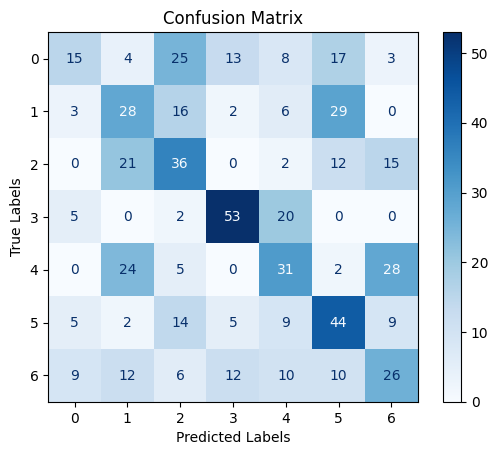

In [ ]:
# Compute F1 scores and confusion matrix
print("Class-wise F1 Scores:", metrics.f1_score(label, target, average=None))
weighted_f1_score = metrics.f1_score(label, target, average='weighted')
print("Weighted Average F1 Score:", weighted_f1_score)

# Compute and display confusion matrix
cm = metrics.confusion_matrix(label, target)
plt.figure(figsize=(8, 6))
metrics.ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.grid(False)
plt.show()

<a id='task2'></a>
<div class=" alert alert-warning">
<p> <b>2.2</b> Use PCA and LDA transformations to reduce the dimensionality of depth images. You should also standardize the values to zero mean and unit variance before the transformations. Fit PCA and LDA for all training images (12x16, 192-dimensional in vectorized form) by choosing 5-dimensional subspace for both PCA and LDA. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 5x1x(5+5). Similar to task 2.1, do the PCA and LDA fusion using NN and evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>

Note: Standardize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes (The expected F1 score for this task should generally fall within the range of 40 to 50)
    
</div>

Step 1: Preprocess Depth Camera Data

In [ ]:

# Preprocess training depth camera data
train_dc = train.drop(columns=['sensor_code_x', 'sensor_x', 'df_x', 'sensor_code_y', 'sensor_y']).copy()
train_dc.rename(columns={'df_y': 'df'}, inplace=True)

# Preprocess testing depth camera data
test_dc = test.drop(columns=['sensor_code_y', 'sensor_y', 'df_x', 'sensor_code_x', 'sensor_x']).copy()
test_dc.rename(columns={'df_y': 'df'}, inplace=True)

Step 2: Standardize Depth Camera Data

In [ ]:
def standardize_depth_data(data):
    """
    Standardize depth camera data by applying z-score normalization and adding target labels.
    """
    return pd.concat([
        pd.DataFrame(stats.zscore(data['df'].iloc[i], axis=1))
        .assign(target=data.iloc[i]['exercise_id'])
        for i in range(len(data['df']))
    ], axis=0)

# Standardize training and testing depth camera data
train_dc_df = standardize_depth_data(train_dc)
test_dc_df = standardize_depth_data(test_dc)

Step 3: Apply PCA and LDA

In [ ]:
# Initialize PCA and LDA
pca = PCA(n_components=5)
lda = LinearDiscriminantAnalysis(n_components=5)

# Apply PCA and LDA on training data
pca_train = pca.fit_transform(train_dc_df.drop('target', axis=1))
lda_train = lda.fit_transform(train_dc_df.drop('target', axis=1), train_dc_df['target'])

# Apply PCA and LDA on testing data
pca_test = pca.transform(test_dc_df.drop('target', axis=1))
lda_test = lda.transform(test_dc_df.drop('target', axis=1))

# Display dataset sizes
print(f"Number of PCA training samples: {len(pca_train)}")
print(f"Number of PCA testing samples: {len(pca_test)}")

Number of PCA training samples: 7430
Number of PCA testing samples: 2990


Step 4: Flatten PCA and LDA Outputs

In [ ]:
def flatten_data(data, group_size):
    """
    Flatten data by concatenating groups of rows into single vectors.
    """
    return [
        list(np.concatenate(data[i:i + group_size], axis=0))
        for i in range(0, len(data), group_size)
    ]

# Flatten PCA and LDA outputs
pca_train_flattened = flatten_data(pca_train, group_size=5)
lda_train_flattened = flatten_data(lda_train, group_size=5)
pca_test_flattened = flatten_data(pca_test, group_size=5)
lda_test_flattened = flatten_data(lda_test, group_size=5)

Step 5: Compute Residuals for PCA and LDA

In [ ]:
def compute_residuals(test_data, train_data):
    """
    Compute residuals between test and train data using the sum of squared differences.
    """
    return [
        np.sum(np.square(np.array(test_data[i]) - np.array(train_data)), axis=1)
        for i in range(len(test_data))
    ]

# Compute residuals
pca_residuals = compute_residuals(pca_test_flattened, pca_train_flattened)
lda_residuals = compute_residuals(lda_test_flattened, lda_train_flattened)

Step 6: Normalize Residuals

In [ ]:
# Normalize residuals
pca_normalized = pd.DataFrame(minmax_scale(pca_residuals, feature_range=(0, 1), axis=1))
lda_normalized = pd.DataFrame(minmax_scale(lda_residuals, feature_range=(0, 1), axis=1))

# Combine normalized residuals
combined_scores = (pca_normalized + lda_normalized) / 2

Step 7: Map Combined Scores to Target Values

Class-wise F1 Scores:
Class 0: 0.25
Class 1: 0.32
Class 2: 0.38
Class 3: 0.64
Class 4: 0.35
Class 5: 0.44
Class 6: 0.31

Weighted Average F1 Score: 0.38


<Figure size 800x600 with 0 Axes>

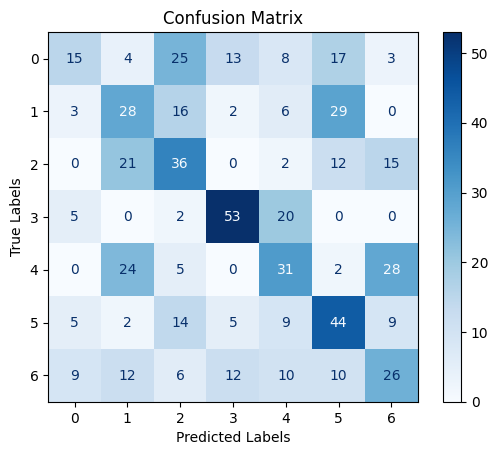

In [ ]:
def extract_targets(data, group_size):
    """
    Extract target values from the data at specified intervals.
    """
    return pd.DataFrame([
        data['target'].iloc[i] for i in range(0, len(data), group_size)
    ])

# Extract training and testing target values
train_targets_dc = extract_targets(train_dc_df, group_size=5)
test_targets_dc = extract_targets(test_dc_df, group_size=5)

# Map combined scores to nearest training targets
predicted_targets = [
    train_targets_dc.iloc[np.argmin(combined_scores.iloc[i])][0]
    for i in range(len(combined_scores))
]
true_labels = [
    test_targets_dc.iloc[i][0] for i in range(len(combined_scores))
]

# Convert to DataFrames
predicted_labels = pd.DataFrame(predicted_targets)
true_labels = pd.DataFrame(true_labels)



# Compute F1 scores and confusion matrix
classwise_f1_scores = metrics.f1_score(label, target, average=None)
weighted_f1_score = metrics.f1_score(label, target, average='weighted')

# Print F1 scores
print("Class-wise F1 Scores:")
for idx, score in enumerate(classwise_f1_scores):
    print(f"Class {idx}: {score:.2f}")
print("\nWeighted Average F1 Score:", f"{weighted_f1_score:.2f}")

# Compute confusion matrix
confusion_matrix = metrics.confusion_matrix(label, target)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
metrics.ConfusionMatrixDisplay(confusion_matrix).plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.grid(False)
plt.show()


# 3. Feature extraction and feature-level fusion for multimodal classification

<a id='task3'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 3.</b>

Prepare new feature sets for each modality and combine them to single feature representation. Compare two classifiers from scikit-learn. Train classifiers using joint feature presentation. Evaluate and compare the result using testing dataset. Do the subtasks given as
<br>   

<p> <b>3.1</b> Similar to task 2.1, calculate PCA for accelerometer, but choose now the 10 largest principal components as 10-dim feature vector for each window. In addition, for each window calculate mean and standard deviation of each three acc channels as statistical features, resulting 6-dimensional vector. Combine these to 36-dimensional final feature vector.</p>

Document your work.
    
</div>

Step 1: Compute Mean and Standard Deviation for Training and Testing Data

In [ ]:
# Function to calculate row-wise statistics (mean and standard deviation)
def calculate_row_statistics(dataframe, exclude_columns):
    """
    Calculate row-wise mean and standard deviation for the given DataFrame, excluding specified columns.

    Parameters:
    - dataframe: Input DataFrame.
    - exclude_columns: List of columns to exclude from calculations.

    Returns:
    - DataFrame with added 'mean' and 'std' columns.
    """
    # Calculate mean and standard deviation
    statistics_df = dataframe.copy()
    statistics_df['mean'] = np.mean(statistics_df.drop(columns=exclude_columns), axis=1)
    statistics_df['std'] = np.std(statistics_df.drop(columns=exclude_columns), axis=1)

    # Reset indices for the new columns
    statistics_df[['mean', 'std']] = statistics_df[['mean', 'std']].reset_index(drop=True)

    return statistics_df

# Apply the function to training and testing datasets
train_acc_df = calculate_row_statistics(train_acc_df, exclude_columns=['target'])
test_acc_df = calculate_row_statistics(test_acc_df, exclude_columns=['target'])

Step 2: Apply PCA to Training and Testing Data

In [ ]:

# Function to apply PCA on a dataset
def apply_pca(dataframe, excluded_columns, n_components):
    """
    Apply PCA to the given DataFrame after excluding specified columns.

    Parameters:
    - dataframe: Input DataFrame.
    - excluded_columns: List of columns to exclude before applying PCA.
    - n_components: Number of PCA components to compute.

    Returns:
    - Tuple containing:
        - PCA-transformed data as a NumPy array.
        - PCA model fitted to the data.
    """
    # Initialize PCA with the specified number of components
    pca_model = PCA(n_components=n_components)

    # Apply PCA transformation
    transformed_data = pca_model.fit_transform(dataframe.drop(columns=excluded_columns))

    return transformed_data, pca_model

# Apply PCA on training and testing datasets
Train_Data_PCA, pca_model = apply_pca(train_acc_df, excluded_columns=['mean', 'std', 'target'], n_components=10)
Test_Data_PCA = pca_model.transform(test_acc_df.drop(columns=['mean', 'std', 'target']))

# Print information about PCA-transformed data
print("Length of PCA training data:", len(Train_Data_PCA))
print("Number of PCA components:", len(Test_Data_PCA[0]))

Length of PCA training data: 4458
Number of PCA components: 10


Step 3: Transform PCA Results into DataFrames

In [ ]:
# Convert PCA-transformed data into DataFrames
Train_Data_PCA = pd.DataFrame(Train_Data_PCA)
Test_Data_PCA = pd.DataFrame(Test_Data_PCA)

# Add mean and standard deviation columns to PCA DataFrames
Train_Data_PCA[['mean', 'std']] = train_acc_df[['mean', 'std']].values
Test_Data_PCA[['mean', 'std']] = test_acc_df[['mean', 'std']].values

Step 4: Concatenate PCA Features into 36-Dimensional Vectors

In [ ]:
# Concatenate every three consecutive PCA rows into 36-dimensional vectors for training data
PCA_Training_Data_Concatenated_Acc = [
    np.concatenate([Train_Data_PCA.iloc[i], Train_Data_PCA.iloc[i+1], Train_Data_PCA.iloc[i+2]], axis=0)
    for i in range(0, len(Train_Data_PCA), 3)
]

# Concatenate every three consecutive PCA rows into 36-dimensional vectors for testing data
PCA_Test_Data_Concatenated_Acc = [
    np.concatenate([Test_Data_PCA.iloc[i], Test_Data_PCA.iloc[i+1], Test_Data_PCA.iloc[i+2]], axis=0)
    for i in range(0, len(Test_Data_PCA), 3)
]

Step 5: Create DataFrames for Concatenated Vectors

In [ ]:
# Create DataFrames for concatenated training and testing vectors
df_acc_vector_train = pd.DataFrame(PCA_Training_Data_Concatenated_Acc)
df_acc_vector_test = pd.DataFrame(PCA_Test_Data_Concatenated_Acc)

# Print the dimension of the first concatenated feature vector
print("The dimension of final feature vector:", len(PCA_Test_Data_Concatenated_Acc[0]))



The dimension of final feature vector: 36


Step 6: Visualize Concatenated Feature Vectors

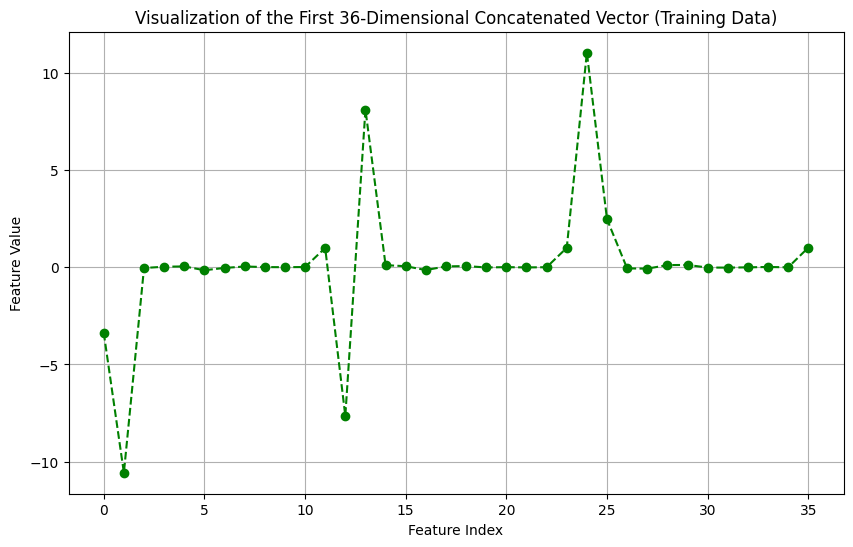

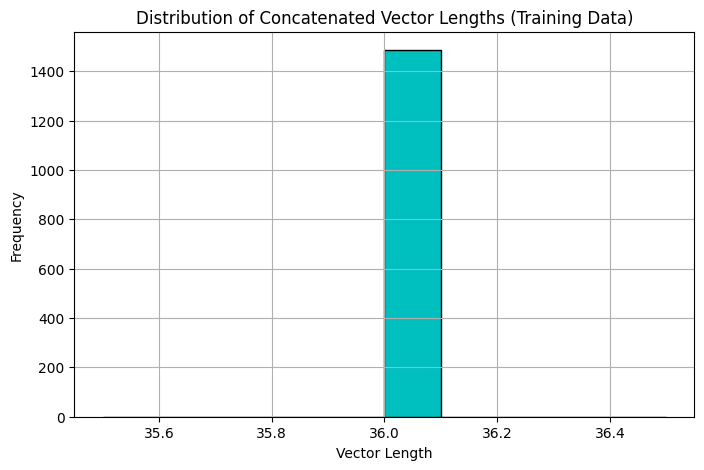

In [ ]:
# Visualize the first concatenated vector in training data
plt.figure(figsize=(10, 6))
plt.plot(df_acc_vector_train.iloc[0], marker='o', linestyle='--', color='g')
plt.title("Visualization of the First 36-Dimensional Concatenated Vector (Training Data)")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.grid(True)
plt.show()

# Visualize the distribution of concatenated vector lengths for training data
vector_lengths = [len(vec) for vec in PCA_Training_Data_Concatenated_Acc]
plt.figure(figsize=(8, 5))
plt.hist(vector_lengths, bins=10, color='c', edgecolor='black')
plt.title("Distribution of Concatenated Vector Lengths (Training Data)")
plt.xlabel("Vector Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

<a id='task3'></a>
<div class=" alert alert-warning">

<p> <b>3.2</b> Similar to task 2.2, calculate the PCA for depth images using same setup, but now choose the 10 largest principal components as feature vector. Concatenate the image sequence forming 50-dimensional feature vector from each windowed example.</p>

Document your work.
    
</div>

In [ ]:
# PCA to train and test datasets for depth camera
pca = PCA(n_components=10)
train_features = train_dc_df.drop(['target'], axis=1)
test_features = test_dc_df.drop(['target'], axis=1)

pca_train_dc = pd.DataFrame(pca.fit_transform(train_features))
pca_test_dc = pd.DataFrame(pca.transform(test_features))

# Dimensions of PCA results
print("Length of PCA training data:", len(pca_train_dc))
print("Length of PCA components:", len(pca_train_dc.iloc[0]))

# Creating concatenated vectors for PCA training data
pca_train_concat_dc = []
for i in range(0, len(pca_train_dc), 5):
    concatenated_vector = np.concatenate([pca_train_dc.iloc[i + j] for j in range(5)], axis=0)
    pca_train_concat_dc.append(concatenated_vector)

print("The dimension of final feature vector:", len(pca_train_concat_dc[0]))

# Creating concatenated vectors for PCA test data
pca_test_concat_dc = []
for i in range(0, len(pca_test_dc), 5):
    concatenated_vector = np.concatenate([pca_test_dc.iloc[i + j] for j in range(5)], axis=0)
    pca_test_concat_dc.append(concatenated_vector)

print("The length of the first vector in the concatenated set: ", len(pca_test_concat_dc))

# DataFrames for concatenated vectors from PCA train and test data
df_dc_vector_train = pd.DataFrame(pca_train_concat_dc)
df_dc_vector_test = pd.DataFrame(pca_test_concat_dc)

print("The length of the train dataframe: ", len(df_dc_vector_train))


Length of PCA training data: 7430
Length of PCA components: 10
The dimension of final feature vector: 50
The length of the first vector in the concatenated set:  598
The length of the train dataframe:  1486


In [ ]:

#  PCA to train and test datasets for depth camera
pca = PCA(n_components=10)
pca_train_dc = pd.DataFrame(pca.fit_transform(train_dc_df.drop(['target'], axis=1)))
pca_test_dc = pd.DataFrame(pca.transform(test_dc_df.drop(['target'], axis=1)))

# dimensions of PCA results
print("Length of PCA training data:", len(pca_train_dc))
print("Length of PCA components:", len(pca_train_dc.iloc[0]))

# Converting PCA results to DataFrames
pca_train_dc = pd.DataFrame(pca_train_dc)
pca_test_dc = pd.DataFrame(pca_test_dc)

# 50-dimensional concatenated vectors for PCA training data with depth camera
pca_train_concat_dc = [np.concatenate([pca_train_dc.iloc[i+j] for j in range(5)], axis=0) for i in range(0, len(pca_train_dc), 5)]

# lengths of the first vector in the concatenated set
print("The dimension of final feature vector:", len(pca_train_concat_dc[0]))

Length of PCA training data: 7430
Length of PCA components: 10
The dimension of final feature vector: 50


In [ ]:
# 50-dimensional concatenated vectors for PCA test data with depth camera
pca_test_concat_dc = [np.concatenate([pca_test_dc.iloc[i+j] for j in range(5)], axis=0) for i in range(0, len(pca_test_dc), 5)]

# lengths of the first vector in the concatenated set
print("the length of the first vector in the concatenated set: ", len(pca_test_concat_dc))

# dataframes for concatenated vectors from PCA train and test data with depth camera
df_dc_vector_train = pd.DataFrame([np.concatenate([pca_train_dc.iloc[i+j] for j in range(5)], axis=0) for i in range(0, len(pca_train_dc), 5)])
df_dc_vector_test = pd.DataFrame([np.concatenate([pca_test_dc.iloc[i+j] for j in range(5)], axis=0) for i in range(0, len(pca_test_dc), 5)])

# lengths of the train dataframe
print("the length of the train dataframe: ", len(df_dc_vector_train))

the length of the first vector in the concatenated set:  598
the length of the train dataframe:  1486


<a id='task3'></a>
<div class=" alert alert-warning">

<p> <b>3.3</b> Form a joint feature presentation of features extracted in 3.1 and 3.2, resulting 86-dimensional feature vector for each example. Normalize data between 0-1 using the training dataset. Use support vector machine (SVM) with RBF-kernel and Gaussian naiveBayes classifier (use default parameter values for both classifiers). Train the classifiers and evaluate and compare classifiers on testset using confusion matrices and F1 scores.</p>

Note: Normalize the data along each axis.
<br>

Document your work, evaluate the results, and analyse the outcomes. (The expected F1 score for this task should generally fall within the range of 55 to 70)
    
</div>

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM F1 score: [0.57591623 0.36363636 0.04301075 0.78172589 1.         0.56692913
 0.59622642]
SVM Weighted Average F1 Score: 0.562381837769775
SVM Confusion matrix:
 [[55  0  0 30  0  0  0]
 [19 26  5  5  0  0 29]
 [29 30  2  5  0  0 20]
 [ 3  0  0 77  0  0  0]
 [ 0  0  0  0 90  0  0]
 [ 0  0  0  0  0 36 52]
 [ 0  3  0  0  0  3 79]]
GNB F1 score : [0.20645161 0.31847134 0.41176471 0.30327869 0.71428571 0.85294118
 0.63492063]
GNB Weighted Average F1 Score: 0.49713516893761145
Confusion matrix for Gaussian Naive Bayes:
 [[16  7 10 52  0  0  0]
 [ 5 25 36 18  0  0  0]
 [ 0 25 35 26  0  0  0]
 [37  5  1 37  0  0  0]
 [12  9  2 17 50  0  0]
 [ 0  0  0  0  0 87  1]
 [ 0  2  0 14  0 29 40]]


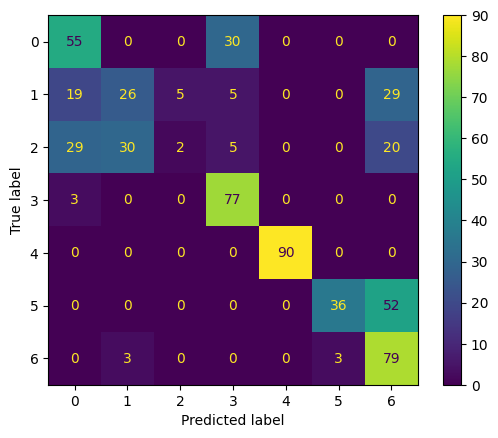

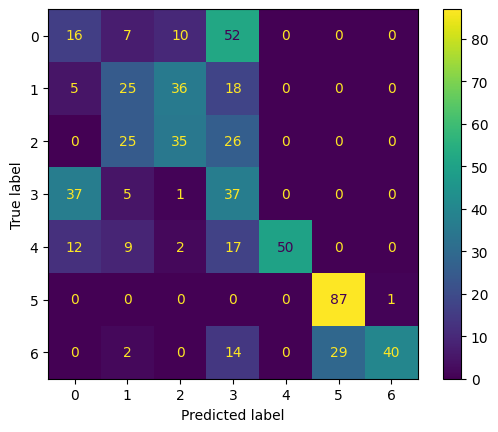

In [ ]:

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import minmax_scale
from sklearn import metrics
import numpy as np
import pandas as pd



# Concatenating accelerometer and depth camera vectors into a DataFrame for training
acc_dc_full_train = pd.concat(
    [pd.concat([df_acc_vector_train.iloc[i], df_dc_vector_train.iloc[i]], axis=0)
     for i in range(len(df_dc_vector_train))],
    axis=1
).transpose()

# Concatenating accelerometer and depth camera vectors into a DataFrame for testing
acc_dc_full_test = pd.concat(
    [pd.concat([df_acc_vector_test.iloc[i], df_dc_vector_test.iloc[i]], axis=0)
     for i in range(len(df_dc_vector_test))],
    axis=1
).transpose()



# Normalizing the training data
normalized_full_train = pd.DataFrame(
    minmax_scale(acc_dc_full_train, feature_range=(0, 1), axis=1, copy=True)
)

# Normalizing the testing data
normalized_full_test = pd.DataFrame(
    minmax_scale(acc_dc_full_test, feature_range=(0, 1), axis=1, copy=True)
)



# Initialize and train the SVM classifier
clf = SVC(kernel='rbf')
clf.fit(normalized_full_train, train_targets_dc)

# Predict using the trained SVM classifier
predicted = clf.predict(normalized_full_test)

# Evaluate the performance of the SVM
f1_score_svm = metrics.f1_score(test_targets_dc, predicted, average=None)
print("SVM F1 score:", f1_score_svm)

weighted_f1_score_svm = metrics.f1_score(test_targets_dc, predicted, average='weighted')
print("SVM Weighted Average F1 Score:", weighted_f1_score_svm)

print("SVM Confusion matrix:\n", metrics.confusion_matrix(test_targets_dc, predicted))
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(test_targets_dc, predicted)).plot()



# Initialize and train the Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(normalized_full_train, np.ravel(train_targets_dc))

# Predict using the trained Gaussian Naive Bayes classifier
predicted_gnb = gnb.predict(normalized_full_test)

# Evaluate the performance of the Gaussian Naive Bayes
f1_score_gnb = metrics.f1_score(test_targets_dc, predicted_gnb, average=None)
print("GNB F1 score :", f1_score_gnb)

weighted_f1_score_gnb = metrics.f1_score(test_targets_dc, predicted_gnb, average='weighted')
print("GNB Weighted Average F1 Score:", weighted_f1_score_gnb)

print("Confusion matrix for Gaussian Naive Bayes:\n", metrics.confusion_matrix(test_targets_dc, predicted_gnb))
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(test_targets_dc, predicted_gnb)).plot()


# 4. Decision-level fusion for multimodal classification

<a id='task4'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 4.</b>

Use features calculated for each modality in task 3. Choose base classifier for each modality from scikit-learn. Train classifiers for each modality feature presentations separately and combine the outputs in decision level. Evaluate and compare the result on testing dataset. Do the subtasks given as
<br>
<br>
<p> <b>4.1</b> Use base classifiers of support vector machine (SVM) with RBF-kernel and AdaBoost classifier (with random_state=0).
Normalize data between 0-1 using the training dataset. Train the base classifiers by tuning the model parameters (<i>C</i> parameter and RBF-kernel <i>gamma</i> in SVM as well as <i>n_estimators</i> and <i>learning_rate</i> in Adaboost) using 10-fold cross-validation on training dataset to find optimal set of parameters (hint: use GridSearchCV from scikit-learn). For grid search use the following values $C = [0.1, 1.0, 10.0, 100.0]$, $gamma=[0.1, 0.25, 0.5, 0.75, 1.0, 2.0]$, $n\_estimators = [50, 100, 500, 1000]$, and $learning\_rate = [0.1, 0.25, 0.5, 0.75,1.0]$.<br>
Choose the best parameters and train the classifiers for each modality on whole training dataset. Is there a possibility that classifiers will overfit to training data using this parameter selection strategy? If so, why? </p>

Note: Normalize the data along each axis.
<br>

Document your work, answer the given question, evaluate the results, and analyse the outcomes.
    
</div>

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

#Step 1: Normalize Data
def normalize_data(train_data, test_data):
    """
    Normalize training and testing datasets using MinMaxScaler.
    """
    scaler = MinMaxScaler()
    normalized_train = pd.DataFrame(scaler.fit_transform(train_data))
    normalized_test = pd.DataFrame(scaler.transform(test_data))
    return normalized_train, normalized_test

# Normalize training and testing datasets
Normalized_Data_Train, Normalized_Data_Test = normalize_data(acc_dc_full_train, acc_dc_full_test)

#Step 2: Define Parameter Grids
def create_parameter_grid(model_type):
    """
    Create parameter grids for different classifiers.
    """
    if model_type == 'SVM':
        return {'C': [0.1, 1.0, 10.0, 100.0], 'gamma': [0.1, 0.25, 0.5, 0.75, 1.0, 2.0]}
    elif model_type == 'AdaBoost':
        return {'n_estimators': [50, 100, 500, 1000], 'learning_rate': [0.1, 0.25, 0.5, 0.75, 1.0]}
    else:
        raise ValueError("Unsupported model type")

# Define parameter grids for SVM and AdaBoost
SVM_Classifier_Parameter_Grid = create_parameter_grid('SVM')
Adaboost_Model_Parameter_Grid = create_parameter_grid('AdaBoost')

# Step 3: Perform Grid Search
def perform_grid_search(model, param_grid, train_data, train_labels, cv=10):
    """
    Perform GridSearchCV to find the best hyperparameters for a given model.
    """
    grid_search = GridSearchCV(
        model, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1
    )
    grid_search.fit(train_data, train_labels)
    return grid_search

# Perform GridSearchCV for SVM
SVM_Classifier = SVC(kernel='rbf')
SVM_Classifier_Grid_Search = perform_grid_search(
    SVM_Classifier, SVM_Classifier_Parameter_Grid, Normalized_Data_Train, train_targets_dc
)

# Perform GridSearchCV for AdaBoost
Adaboost_Classifier = AdaBoostClassifier(random_state=0)
Adaboost_Classifier_Grid_Search = perform_grid_search(
    Adaboost_Classifier, Adaboost_Model_Parameter_Grid, Normalized_Data_Train, train_targets_dc
)

# Step 4: Train Models with Best Parameters
def train_model_with_best_params(model, best_params, train_data, train_labels):
    """
    Train the model using the best parameters obtained from GridSearchCV.
    """
    if isinstance(model, SVC):
        best_model = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])
    elif isinstance(model, AdaBoostClassifier):
        best_model = AdaBoostClassifier(
            n_estimators=best_params['n_estimators'],
            learning_rate=best_params['learning_rate'],
            random_state=0
        )
    else:
        raise ValueError("Unsupported model type")
    best_model.fit(train_data, train_labels)
    return best_model

# Train SVM with the best parameters
svm_classifier_best_params = train_model_with_best_params(
    SVM_Classifier, SVM_Classifier_Grid_Search.best_params_, Normalized_Data_Train, train_targets_dc
)

# Train AdaBoost with the best parameters
Adaboost_Classifier_Best_Parameters = train_model_with_best_params(
    Adaboost_Classifier, Adaboost_Classifier_Grid_Search.best_params_, Normalized_Data_Train, train_targets_dc
)

# Step 5: Display Results
print("Best parameters for SVM:", SVM_Classifier_Grid_Search.best_params_)
print("Best parameters for AdaBoost:", Adaboost_Classifier_Grid_Search.best_params_)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best parameters for SVM: {'C': 1.0, 'gamma': 0.75}
Best parameters for AdaBoost: {'learning_rate': 1.0, 'n_estimators': 1000}


<a id='task4'></a>
<div class=" alert alert-warning">


<p> <b>4.2</b> Predict probabilistic outputs of each trained classifier for both modalities using the test set. </p>
<br>
Document your work, evaluate the results, and analyse the outcomes.
    
</div>

In [ ]:

from sklearn.calibration import CalibratedClassifierCV

### Step 1: Train Classifiers with Best Parameters ###
def train_best_model(model, best_params, train_data, train_labels, probability=False):
    """
    Train the given model with the best parameters and optional probability estimates.
    """
    if isinstance(model, SVC):
        best_model = SVC(
            kernel='rbf',
            C=best_params['C'],
            gamma=best_params['gamma'],
            probability=probability
        )
    else:
        best_model = model.set_params(**best_params)
    best_model.fit(train_data, train_labels)
    return best_model

# Train SVM classifier with probability estimates
SVM_Classifier_Best_Parameters = train_best_model(
    SVC(), SVM_Classifier_Grid_Search.best_params_, Normalized_Data_Train, train_targets_dc, probability=True
)

# Train AdaBoost classifier
Adaboost_Classifier_Best_Parameters = train_best_model(
    Adaboost_Classifier, Adaboost_Classifier_Grid_Search.best_params_, Normalized_Data_Train, train_targets_dc
)

### Step 2: Predict Probabilistic Outputs ###
def predict_probabilities(model, test_data, description):
    """
    Predict probabilistic outputs for a model.
    """
    probabilities = model.predict_proba(test_data)
    print(f"Predicted probabilities for {description}:\n", probabilities[:5])
    return probabilities

# Predict probabilities for accelerometer data
SVM_Classifier_Probability_Acc = predict_probabilities(
    SVM_Classifier_Best_Parameters, Normalized_Data_Test, "SVM (Accelerometer)"
)
Adaboost_Classifier_Probability_Acc = predict_probabilities(
    Adaboost_Classifier_Best_Parameters, Normalized_Data_Test, "AdaBoost (Accelerometer)"
)

### Step 3: Calibrate Classifiers ###
def calibrate_classifier(model, train_data, train_labels, method='sigmoid'):
    """
    Calibrate the given model using CalibratedClassifierCV.
    """
    calibrated_model = CalibratedClassifierCV(model, method=method, cv='prefit')
    calibrated_model.fit(train_data, train_labels)
    return calibrated_model

# Calibrate SVM and AdaBoost classifiers for accelerometer data
SVM_Classifier_Calibrated_Acc = calibrate_classifier(
    SVM_Classifier_Best_Parameters, Normalized_Data_Train, train_targets_dc
)
Adaboost_Classifier_Calibrated_Acc = calibrate_classifier(
    Adaboost_Classifier_Best_Parameters, Normalized_Data_Train, train_targets_dc
)

# Predict calibrated probabilities for accelerometer data
SVM_Classifier_Probability_Calibrated_Acc = predict_probabilities(
    SVM_Classifier_Calibrated_Acc, Normalized_Data_Test, "Calibrated SVM (Accelerometer)"
)
Adaboost_Classifier_Probability_Calibrated_Acc = predict_probabilities(
    Adaboost_Classifier_Calibrated_Acc, Normalized_Data_Test, "Calibrated AdaBoost (Accelerometer)"
)

### Step 4: Predict and Calibrate for Depth Data ###
# Predict probabilities for depth data
SVM_Classifier_Probability_Depth = predict_probabilities(
    SVM_Classifier_Best_Parameters, Normalized_Data_Test, "SVM (Depth)"
)
Adaboost_Classifier_Probability_Depth = predict_probabilities(
    Adaboost_Classifier_Best_Parameters, Normalized_Data_Test, "AdaBoost (Depth)"
)

# Calibrate classifiers for depth data
SVM_Classifier_Calibrated_Depth = calibrate_classifier(
    SVM_Classifier_Best_Parameters, Normalized_Data_Train, train_targets_dc
)
Adaboost_Classifier_Calibrated_Depth = calibrate_classifier(
    Adaboost_Classifier_Best_Parameters, Normalized_Data_Train, train_targets_dc
)

# Predict calibrated probabilities for depth data
SVM_Classifier_Probability_Depth_Calibrated = predict_probabilities(
    SVM_Classifier_Calibrated_Depth, Normalized_Data_Test, "Calibrated SVM (Depth)"
)
Adaboost_Classifier_Probability_Depth_Calibrated = predict_probabilities(
    Adaboost_Classifier_Calibrated_Depth, Normalized_Data_Test, "Calibrated AdaBoost (Depth)"
)




/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Predicted probabilities for SVM (Accelerometer):
 [[7.50019514e-03 2.08945652e-03 1.37120098e-03 1.79096745e-02
  2.05418475e-03 1.35134079e-02 9.55561880e-01]
 [6.32482791e-02 7.36398219e-03 4.33635623e-03 4.20204777e-02
  3.16315662e-03 1.49649422e-02 8.64902806e-01]
 [2.41071793e-02 4.69091748e-03 2.73630895e-03 5.13386597e-02
  3.51688111e-03 1.95664161e-02 8.94043637e-01]
 [2.38950340e-03 1.53294967e-03 8.77160213e-04 2.11335810e-02
  2.48506591e-03 8.26974940e-03 9.63311990e-01]
 [8.87155178e-03 3.21878558e-03 1.91050741e-03 3.36579067e-02
  3.32701025e-03 2.03496445e-02 9.28664594e-01]]
Predicted probabilities for AdaBoost (Accelerometer):
 [[0.14254791 0.14219597 0.14269631 0.14322151 0.13964803 0.14460882
  0.14508145]
 [0.14266494 0.14208767 0.14184921 0.14339166 0.14015282 0.1446225
  0.14523119]
 [0.14240839 0.14193319 0.14106621 0.14330994 0.14068389 0.14490123
  0.14569715]
 [0.1423348  0.14293437 0.14220037 0.14357859 0.13984896 0.14437589
  0.14472703]
 [0.14250692 0.14

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Predicted probabilities for Calibrated SVM (Accelerometer):
 [[1.39231007e-11 1.61197819e-14 1.95232524e-15 1.88456622e-06
  1.68276115e-06 2.15521138e-02 9.78444319e-01]
 [4.31978941e-03 2.10644074e-14 2.22731625e-15 1.71048041e-06
  1.71463648e-06 1.30588217e-08 9.95676772e-01]
 [2.49469978e-07 1.83330123e-14 2.02573843e-15 8.82027669e-03
  1.72337692e-06 3.01673295e-08 9.91177720e-01]
 [4.75267522e-12 1.68865735e-14 1.85490658e-15 2.63487547e-06
  1.71976494e-06 1.78633701e-02 9.82132275e-01]
 [1.01337304e-11 1.74185232e-14 1.93345793e-15 2.27957878e-06
  1.71647146e-06 2.08758269e-02 9.79120177e-01]]
Predicted probabilities for Calibrated AdaBoost (Accelerometer):
 [[8.26640125e-07 1.94189755e-06 1.36798030e-08 6.88807201e-06
  1.20746205e-07 3.62526051e-01 6.37464158e-01]
 [1.53487451e-06 1.09376228e-06 1.18851090e-11 1.93042130e-05
  7.18738871e-07 3.42731328e-01 6.57246021e-01]
 [2.56812065e-07 4.08349728e-07 1.39586833e-14 8.69440268e-06
  3.83352237e-06 3.49526026e-01 6.504607

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:337: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Predicted probabilities for Calibrated SVM (Depth):
 [[1.39231007e-11 1.61197819e-14 1.95232524e-15 1.88456622e-06
  1.68276115e-06 2.15521138e-02 9.78444319e-01]
 [4.31978941e-03 2.10644074e-14 2.22731625e-15 1.71048041e-06
  1.71463648e-06 1.30588217e-08 9.95676772e-01]
 [2.49469978e-07 1.83330123e-14 2.02573843e-15 8.82027669e-03
  1.72337692e-06 3.01673295e-08 9.91177720e-01]
 [4.75267522e-12 1.68865735e-14 1.85490658e-15 2.63487547e-06
  1.71976494e-06 1.78633701e-02 9.82132275e-01]
 [1.01337304e-11 1.74185232e-14 1.93345793e-15 2.27957878e-06
  1.71647146e-06 2.08758269e-02 9.79120177e-01]]
Predicted probabilities for Calibrated AdaBoost (Depth):
 [[8.26640125e-07 1.94189755e-06 1.36798030e-08 6.88807201e-06
  1.20746205e-07 3.62526051e-01 6.37464158e-01]
 [1.53487451e-06 1.09376228e-06 1.18851090e-11 1.93042130e-05
  7.18738871e-07 3.42731328e-01 6.57246021e-01]
 [2.56812065e-07 4.08349728e-07 1.39586833e-14 8.69440268e-06
  3.83352237e-06 3.49526026e-01 6.50460781e-01]
 [3.0425

<a id='task4'></a>
<div class=" alert alert-warning">
<p> <b>4.3</b> Combine the probabilistic outputs of different modalities by fixed classification rules: max, min, prod, and sum. Evaluate, compare, and analyse the final combined results using confusion matrices and F1 scores. Show results for each base classifier combinations (i.e., $SVM_{acc}+SVM_{depth}$, $AdaBoost_{acc}+AdaBoost_{depth}$, $SVM_{acc}+AdaBoost_{depth}$, $AdaBoost_{acc}+SVM_{depth}$)</p>
<br>
Document your work, evaluate the results, and analyse the outcomes.
    
</div>

In [ ]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Function to combine probabilistic outputs using fixed classification rules
def combine_probabilities(rule, prob_acc, prob_depth):
    """
    Combine probabilistic outputs using a specified rule.
    """
    if rule == 'max':
        combined_probs = np.maximum(prob_acc, prob_depth)
    elif rule == 'min':
        combined_probs = np.minimum(prob_acc, prob_depth)
    elif rule == 'prod':
        combined_probs = prob_acc * prob_depth
    elif rule == 'sum':
        combined_probs = prob_acc + prob_depth
    else:
        raise ValueError("Invalid combination rule provided. Supported rules: 'max', 'min', 'prod', 'sum'.")
    return combined_probs

# Function to encode labels using LabelEncoder
def encode_labels(labels):
    """
    Encode string labels into numeric labels.
    """
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    return encoder, encoded_labels

# Function to evaluate performance of combined probabilistic outputs
def evaluate_combination(rule, prob_acc, prob_depth, true_labels):
    """
    Evaluate the performance of the combination rule.
    """
    # Combine probabilities for accelerometer and depth classifiers
    combined_acc = combine_probabilities(rule, prob_acc, prob_depth)
    combined_depth = combine_probabilities(rule, prob_depth, prob_acc)

    # Combine overall probabilities
    overall_probs = combine_probabilities(rule, combined_acc, combined_depth)

    # Predict labels based on the combined probabilities
    predicted_labels = np.argmax(overall_probs, axis=1)

    # Evaluate performance
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    confusion_mat = confusion_matrix(true_labels, predicted_labels)

    # Return results
    return f1, confusion_mat

# Encode string labels into numeric labels
label_encoder, encoded_test_targets_dc = encode_labels(test_targets_dc)

# Define combination rules to test
combination_rules = ['max', 'min', 'prod', 'sum']

# Iterate through combination rules and evaluate each
for rule in combination_rules:
    print(f"Evaluating Combination Rule: {rule}")

    # Evaluate combined probabilities for accelerometer and depth classifiers
    f1_score_comb, confusion_matrix_comb = evaluate_combination(
        rule,
        SVM_Classifier_Probability_Calibrated_Acc,
        Adaboost_Classifier_Probability_Calibrated_Acc,
        encoded_test_targets_dc
    )

    # Display results
    print(f"F1 Score (Weighted): {f1_score_comb}")
    print(f"Confusion Matrix:\n{confusion_matrix_comb}")
    print("-" * 50)


Evaluating Combination Rule: max
F1 Score (Weighted): 0.631001112302941
Confusion Matrix:
[[85  0  0  0  0  0  0]
 [47 31  6  0  0  0  0]
 [57 29  0  0  0  0  0]
 [ 7  0  0 73  0  0  0]
 [ 0  0  0  4 86  0  0]
 [ 0  0  0  0  0 49 39]
 [ 0  0  0  0  0  5 80]]
--------------------------------------------------
Evaluating Combination Rule: min
F1 Score (Weighted): 0.6300038230615266
Confusion Matrix:
[[85  0  0  0  0  0  0]
 [11 42  6  0  0  0 25]
 [57 29  0  0  0  0  0]
 [ 6  0  0 74  0  0  0]
 [ 0  0  0 15 75  0  0]
 [ 0  0  0  0  0 49 39]
 [ 0  0  0  0  0  5 80]]
--------------------------------------------------
Evaluating Combination Rule: prod
F1 Score (Weighted): 0.6321566096706889
Confusion Matrix:
[[85  0  0  0  0  0  0]
 [17 40  6  0  0  0 21]
 [57 29  0  0  0  0  0]
 [ 7  0  0 73  0  0  0]
 [ 0  0  0 11 79  0  0]
 [ 0  0  0  0  0 49 39]
 [ 0  0  0  0  0  5 80]]
--------------------------------------------------
Evaluating Combination Rule: sum
F1 Score (Weighted): 0.63100111230

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 5. Bonus task: Multimodal biometric identification of persons (optional)

<a id='task5'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 5.</b>

Can you build a classifier that recognizes the person who is performing the exercise? Use same 10 person dataset and split it so that first 25% of each long exercise sequence is used for training and rest 75% of each sequence is used for testing the classifier. Use same 5 second windowing with 3 seconds overlap to prepare the examples. Note that, now the person identity is the class label instead of exercise type. Max. 10 points are given but you can earn points from partial solution, as well.
<br>
<br>
<p> <b>5.1</b> Build a classifier to identify persons based on the features and one of the models given in task 4 (max. 5 points).</p>
<br>
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

In [ ]:
# 5.1

### Your code begins here ###

### Your code ends here ###

<a id='task5'></a>
<div class=" alert alert-warning">

<p> <b>5.2</b> Can you build your own solution (using new features, new classification model or different fusion approaches) to beat the approach in Task 5.1 ? (max. 5 points) </p>
<br>  
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

In [ ]:
# 5.2

### Your code begins here ###

### Your code ends here ###